# Анализ оттока клиентов банка

**Описание проекта**

В банке в последнее время повысился отток, это начинает становиться проблемой, которая угрожает существованию банка.

Исследование проводится для отдела маркетинга, чтобы эффективно выделить сегменты отточных клиентов, чтобы они были однородными, высокоотточными и покрывали максимум проблемных зон банка. Таким образом, маркетинговое воздействие на эти сегменты должно привести к уменьшению оттока.

**Задача:** Проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.

## Обзор данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности 
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
# выведем первые 10 строк таблицы
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_dataset.csv') 
display(data.head(10))

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


Закодируем столбец gender численно. Женский пол 0, мужской - 1.

In [3]:
data = pd.get_dummies(data, columns=['Gender'], drop_first=True)
display(data.head())

,userid,score,City,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn,Gender_М
0,15677338,619,Ярославль,42,2,NaN,1,1,1,101348.88,1,0
1,15690047,608,Рыбинск,41,1,83807.86,1,0,1,112542.58,0,0
2,15662040,502,Ярославль,42,8,159660.80,3,1,0,113931.57,1,0
3,15744090,699,Ярославль,39,1,NaN,2,0,0,93826.63,0,0
4,15780624,850,Рыбинск,43,2,125510.82,1,1,1,79084.10,0,0


In [4]:
# выведем общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Age               10000 non-null  int64  
 4   Objects           10000 non-null  int64  
 5   Balance           6383 non-null   float64
 6   Products          10000 non-null  int64  
 7   CreditCard        10000 non-null  int64  
 8   Loyalty           10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  Churn             10000 non-null  int64  
 11  Gender_М          10000 non-null  uint8  
dtypes: float64(2), int64(8), object(1), uint8(1)
memory usage: 869.3+ KB


Типы данных указаны верно. Стоит привести названия столбцов к нужному виду.

In [5]:
data.columns = data.columns.str.lower()
data = data.rename(columns={
    'userid': 'user_id',
    'creditcard': 'credit_card',
    'estimated_salary': 'salary',
    'gender_м': 'gender'})

 В столбце **balance** пропущено более 35% данных. Нужно изучить природу этих пропусков подробнее.

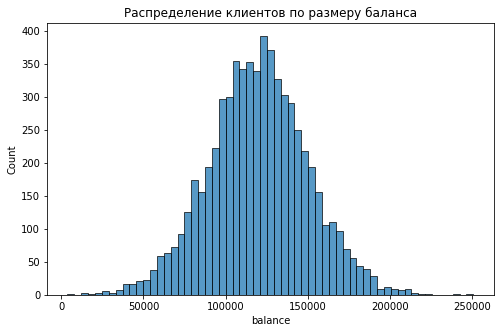

In [6]:
# рассмотрим распределение значений баланса
plt.figure(figsize=(8,5))
sns.histplot(data, x='balance')
plt.title('Распределение клиентов по размеру баланса')
plt.show()

Значение баланса имеет нормальное распределение, отсутствуют клиенты с нулевыми счетами.

In [7]:
# сделаем срез данных, где баланс пропущен, и сравним средние значения баланса
nan_balance = data.query('balance.isna()')

print('Средние значения признаков всего датафрейма')
print(round(data.mean(), 2))
print('------------------------------')
print('Средние значения признаков датафрейма с пропусками в столбце balance')
print(round(nan_balance.mean(), 2))

Средние значения признаков всего датафрейма
user_id        15733676.57
score               650.53
age                  38.92
objects               5.01
balance          119827.49
products              1.53
credit_card           0.71
loyalty               0.52
salary           100090.24
churn                 0.20
gender                0.55
dtype: float64
------------------------------
Средние значения признаков датафрейма с пропусками в столбце balance
user_id        15734685.59
score               649.45
age                  38.43
objects               5.07
balance                NaN
products              1.78
credit_card           0.72
loyalty               0.52
salary            98983.56
churn                 0.14
gender                0.54
dtype: float64


In [8]:
# также изучим, во всех ли городах есть пропуски.
nan_balance.groupby('city')['city'].count()

city
Рыбинск      1199
Ярославль    2418
Name: city, dtype: int64

In [9]:
print(round(nan_balance.groupby('city').mean(), 2).T)
print('------------------------------------------------------')
print(round(data.groupby('city').mean(), 2).T)

city             Рыбинск    Ярославль
user_id      15735505.69  15734278.93
score             651.69       648.35
age                38.50        38.40
objects             5.09         5.06
balance              NaN          NaN
products            1.79         1.78
credit_card         0.71         0.72
loyalty             0.51         0.52
salary          98708.62     99119.89
churn               0.14         0.14
gender              0.55         0.54
------------------------------------------------------
city         Ростов Великий      Рыбинск    Ярославль
user_id         15733291.65  15734654.41  15733386.11
score                651.45       651.33       649.67
age                   39.77        38.89        38.51
objects                5.01         5.03         5.00
balance           119730.12    119814.99    119927.77
products               1.52         1.54         1.53
credit_card            0.71         0.69         0.71
loyalty                0.50         0.53         0.52
sal

- Средние значения признаков схожи, что говорит об отсутствии зависимости пропусков от остальных данных.
- Пропуски есть только в Рыбинске и Ярославле, в Ростове Великом их нет. 
- Пропуски не связаны с оттоком, они есть как у тех, кто является клиентом, так и у тех, кто рассторгнул договор. 

Также ни у кого нет нулевых счетов, можно было бы предположить, что пропуски - это нули, но тогда получается, что в Ростове Великом нет пустых счетов, не похоже на правду. Скорее всего база изначально включает в себя информацию по клиентам с ненулевыми счетами, и сейчас мы имеем дело со сломанной выгрузкой данных. В таком случае оставим пропуски, как есть, чтобы не удалять более 35% данных и не заменять их значениями, которые могут сильно исказить результаты исследования.

## Исследовательский анализ

### Распределение характеристик в разрезе оттока и портрет отточного клиента.

Для начала определим общий уровень оттока по банку.

,churn
churn,
0,7963
1,2037


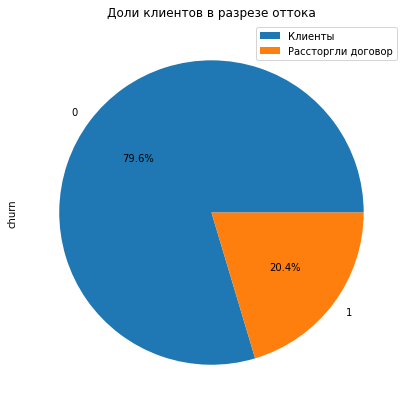

In [10]:
churn_perc = data.groupby('churn').agg({'churn': 'count'})
display(churn_perc)

churn_perc.plot(kind='pie', y='churn', autopct='%1.1f%%', figsize=(7,7))
plt.title('Доли клиентов в разрезе оттока')
plt.legend(['Клиенты', 'Рассторгли договор'])
plt.show()

In [11]:
# функция для формирования графиков распределения
# hue - признак, по которому мы хотим увидеть детализацию данных

def distr_charts(data, hue):
    # дискретные величины:
    for column in ['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty']:
        common_churn_level = data['churn'].mean() * 100
        columns_churn = data.groupby(column)['churn'].mean() * 100
        
        plt.figure(figsize=(8, 5))
        plt.axhline(y= common_churn_level, linewidth=2, linestyle='--', color='k')
        ax = columns_churn.plot(kind='bar', color='c')
        plt.xticks(rotation=0)
        plt.title(f'Процент оттока клиентов по категории {column} относительно среднего по банку')
        plt.show()

    # непрерывные:
    for column in ['score',  'balance', 'salary']:
        plt.figure(figsize=(8,5))
        sns.kdeplot(data=data, x=column, hue=hue, common_norm=False);
        plt.title(f'Распределение клиентов по признаку {column}')
        plt.show()
        
    # столбец age, поскольку у него по оси у много значений, ему нужно попдобрать другой размер
    plt.figure(figsize=(20,8))
    sns.histplot(data=data, x='age', hue=hue, stat="density", common_norm=False);
    plt.title('Распределение клиентов по признаку age')
    plt.show()

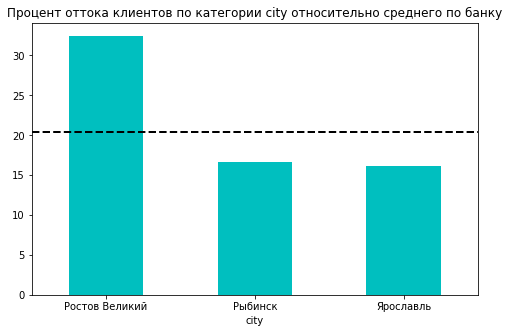

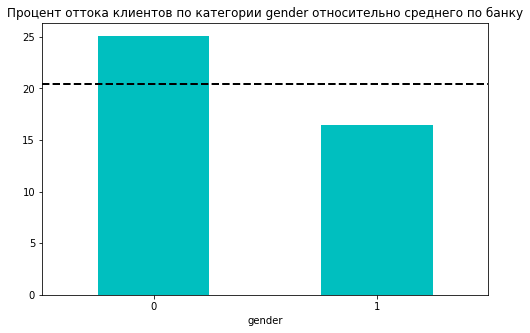

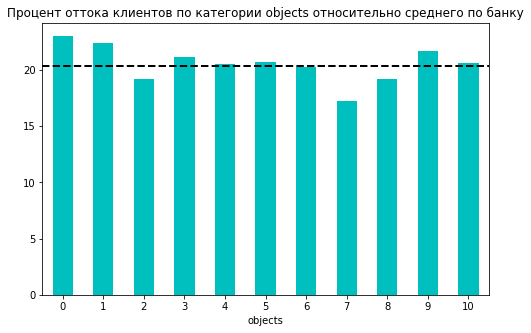

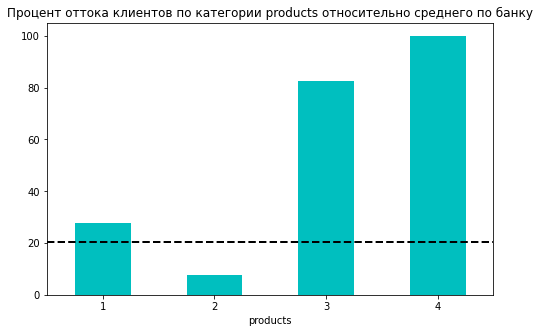

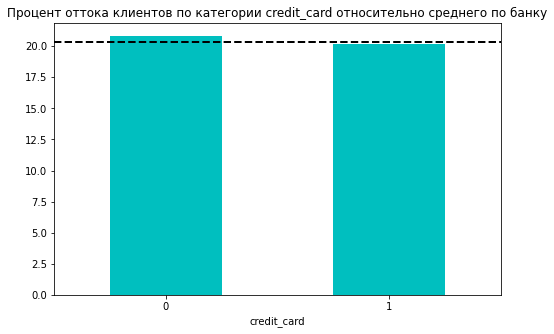

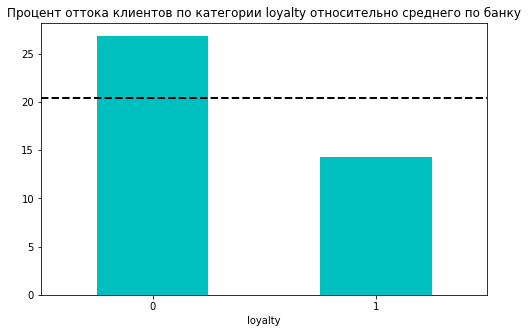

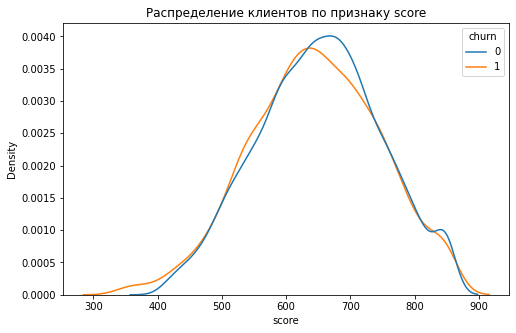

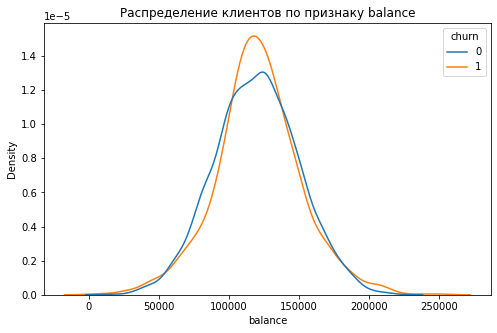

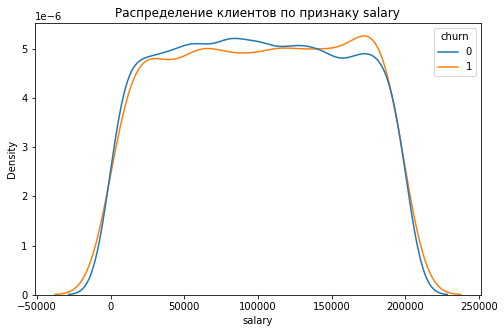

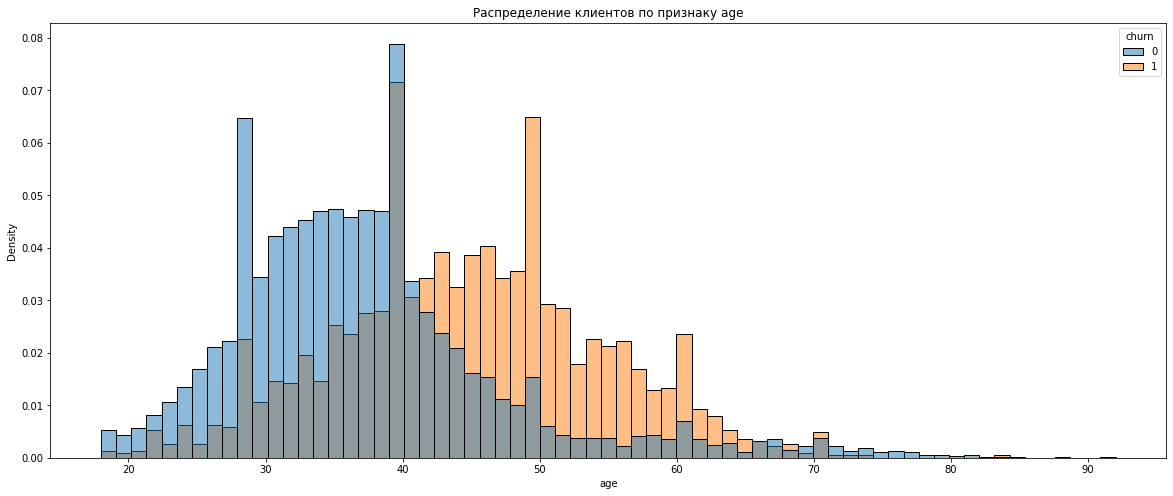

In [12]:
distr_charts(data, 'churn')

Изучим портреты отточных и неотточных клиентов.

In [13]:
# среднее распределение признаков 
portrait = data.groupby('churn').mean().round(2).T
portrait['difference, %'] = round(((portrait[1] - portrait[0]) / portrait[0]) * 100, 2)
display(portrait.sort_values(by='difference, %', ascending=False))

churn,0,1,"difference, %"
age,37.41,44.84,19.86
salary,99738.39,101465.68,1.73
balance,119535.86,120746.97,1.01
user_id,15733903.88,15732787.96,-0.01
score,651.85,645.35,-1.00
credit_card,0.71,0.70,-1.41
objects,5.03,4.93,-1.99
products,1.54,1.48,-3.90
gender,0.57,0.44,-22.81
loyalty,0.55,0.36,-34.55


Обобщённый портрет клиента банка:
- небольшой перевес в сторону мужчин
- возраст 37-38 лет
- 5 объектов в собственности
- средний остаток на счетах 120 тыс. руб 
- средний доход около 100 тыс. руб
- пользуется 1-2 продуктами, один их которых в 70% случаях - кредитная карта
- умеренно активный

Портрет отточного клиента:
- на 22% перевес в сторону женщин
- средний возраст 44-45 лет
- активность на 34% ниже, чем у клиента, пользующегося услугами

Остальные признаки схожи.

**Вывод:**

- общий процент оттока более 20%
- наибольшая доля отточных клиентов в Ростове Великом
- среди отточных клиентов женщин больше почти на 23%, чем мужчин.
- клиенты, пользующиеся двумя продуктами, - группа, которая имеет самую низкую долю оттока. Группа клиентов с одним продуктом имеет процент чуть выше среднего по банку. Клиенты же с 3 и 4 продуктами практически полностью подвержены оттоку.
- пользователи кредитных карт примерно в равных долях остаются с банком.
- среди уходящих пользователей активных на 34% меньше, чем у действующих клиентов.
- основная масса клиентов, которые работают с банком 28-40 лет. Пользователи возраста 42-64 года сильнее подвержены оттоку.

### Матрица корреляций

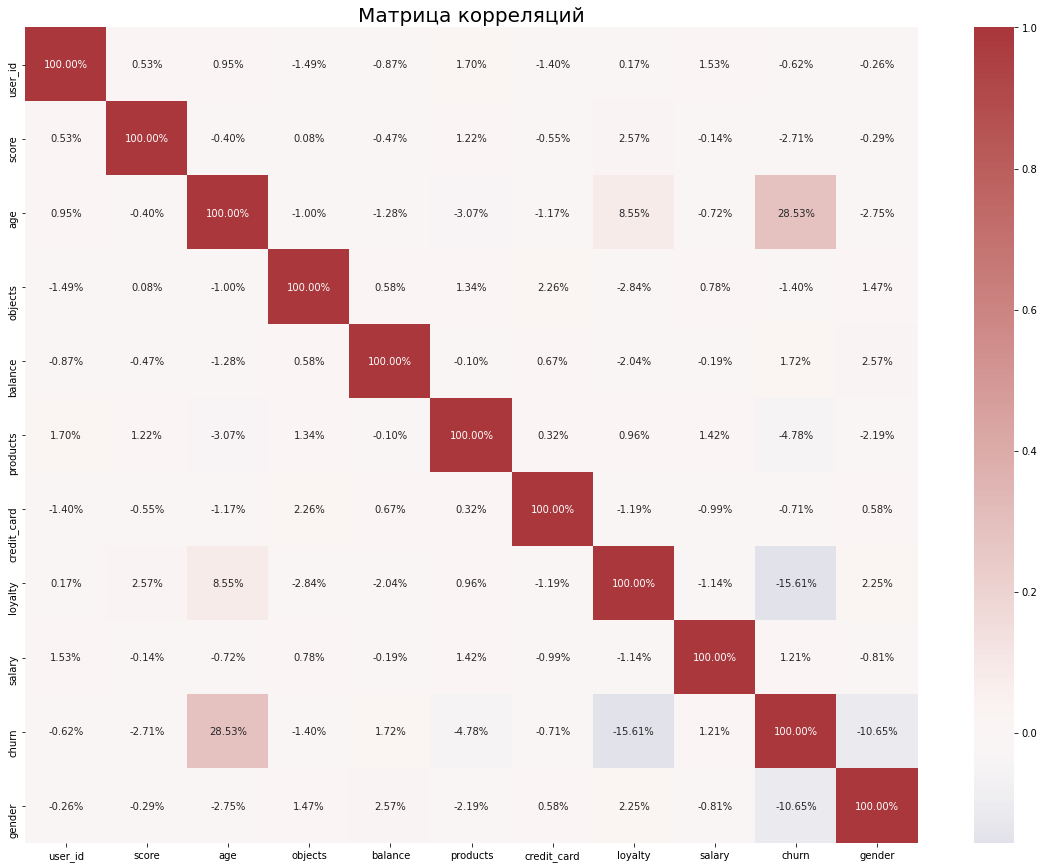

In [14]:
corr_matrix = data.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, center=0 ,cmap="vlag", annot=True, fmt='.2%')
plt.title('Матрица корреляций', fontsize = 20)
plt.show()

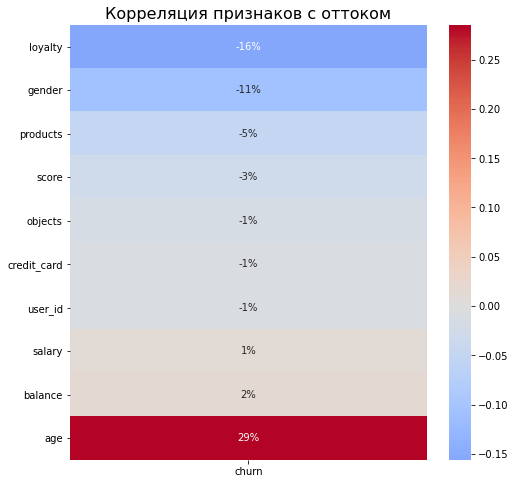

In [15]:
# построим отдельно тепловую карту корреляций признаков непосредственно с оттоком
plt.figure(figsize=(8,8))
sns.heatmap(
    corr_matrix.loc[:,['churn']].drop('churn').sort_values('churn'),
    annot=True, fmt='.0%', cmap='coolwarm', center=0
)
plt.title('Корреляция признаков с оттоком', fontsize = 16)
plt.show()

Присутствуют слабая связь возраста, активности и пола клиентов с оттоком. Чем выше возраст, тем больше уровень оттока. И чем ниже уровень лояльности - тем выше уровень оттока.

## Проверка статистических гипотез

### Гипотеза о различии дохода между теми клиентами, которые ушли и теми, которые остались.

H0: в среднем доходы отточных клиентов равны доходам клиентов, оставшихся с банком.

H1: в среднем доходы отточных клиентов отличаются от доходов клиентов, оставшихся с банком.

#### t-критерий Стьюдента

Три аспекта, которые надо проверить, чтобы понять, можно ли применять t-тест:

- Генеральные совокупности не должны зависеть друг от друга.
- Выборочные средние должны быть нормально распределены.
- Дисперсии рассматриваемых генеральных совокупностей должны быть равны.

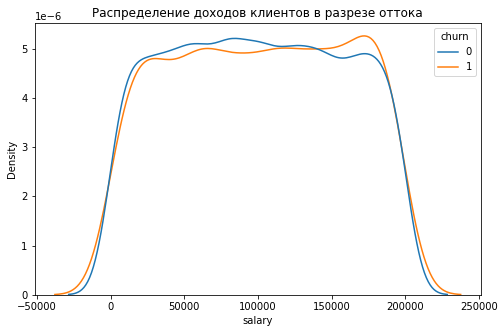

In [16]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='salary', hue='churn', common_norm=False);
plt.title(f'Распределение доходов клиентов в разрезе оттока')
plt.show()

Совокупности не зависят друг от друга, уровень доходу распределён равномерно.

In [17]:
salary_0 = data.query('churn == 0')['salary']
salary_1 = data.query('churn == 1')['salary']

print('Описание salary_0')
print(salary_0.describe().round(2))
print('---------------------')
print('Описание salary_1')
print(salary_1.describe().round(2))

Описание salary_0
count      7963.00
mean      99738.39
std       57405.59
min          90.07
25%       50783.49
50%       99645.04
75%      148609.96
max      199992.48
Name: salary, dtype: float64
---------------------
Описание salary_1
count      2037.00
mean     101465.68
std       57912.42
min          11.58
25%       51907.72
50%      102460.84
75%      152422.91
max      199808.10
Name: salary, dtype: float64


Стандартные отклонения схожи, для анализа можно использовать t-критерий Стьюдента.

In [18]:
alpha = 0.01

results = st.ttest_ind(salary_0, salary_1)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистической разницы в доходах клиентов нет")

p-значение: 0.22644042802223352
Не получилось отвергнуть нулевую гипотезу, статистической разницы в доходах клиентов нет


#### u-критерий Манна-Уитни

Сравним выборки другим способом. Главное отличие u-критерия Манна-Уитни от t-критерия Стьюдента в том, что он работает с рангами, — номерами значений в упорядоченном ряду, — никак не учитывая сами значения. Поэтому им пользуются тогда, когда работа с самими значениями невозможна из-за выбросов, сильно сдвигающих результаты.

In [19]:
alpha = 0.01  # критический уровень статистической значимости

results = st.mannwhitneyu(salary_0, salary_1)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистической разницы в доходах клиентов нет") 

p-значение:  0.22705150930153783
Не получилось отвергнуть нулевую гипотезу, статистической разницы в доходах клиентов нет


Оба теста показали один результат, статистической разницы в доходах отточных и оставшихся клиентов нет. В случае с доходами людей, лучше использовать u-критерий Манна-Уитни, т.к в них могут быть аномальные значения, например в данных есть зарплата в 11 рублей.

### Гипотеза о баллов кредитного скоринга между теми клиентами, которые ушли и теми, которые остались.

H0: в среднем баллы кредитного скоринга клиентов равны скоринговым баллам клиентов, оставшихся с банком.

H1: в среднем баллы кредитного скоринга клиентов отличаются от скоринговых баллов клиентов, оставшихся с банком.

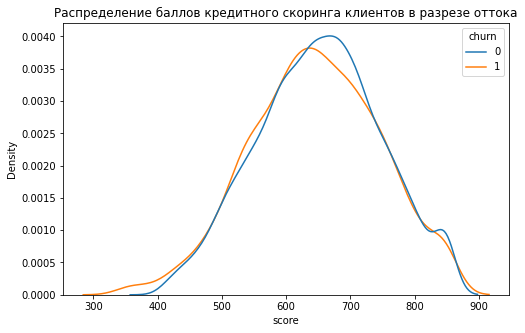

In [20]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='score', hue='churn', common_norm=False);
plt.title(f'Распределение баллов кредитного скоринга клиентов в разрезе оттока')
plt.show()

In [21]:
score_0 = data.query('churn == 0')['score']
score_1 = data.query('churn == 1')['score']

print('Описание score_0')
print(score_0.describe().round(2))
print('---------------------')
print('Описание score_1')
print(score_1.describe().round(2))

Описание score_0
count    7963.00
mean      651.85
std        95.65
min       405.00
25%       585.00
50%       653.00
75%       718.00
max       850.00
Name: score, dtype: float64
---------------------
Описание score_1
count    2037.00
mean      645.35
std       100.32
min       350.00
25%       578.00
50%       646.00
75%       716.00
max       850.00
Name: score, dtype: float64


Распределение нормальное, стандартные отклонения схожи. Применим t-критерий Стьюдента.

In [22]:
alpha = 0.01

results = st.ttest_ind(score_0, score_1)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистической разницы в баллах кредитного скорина клиентов нет")

p-значение: 0.006738213892192373
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, то есть присутствует статистически значимая разница между скорингом отточных и неотточных клиентов.

## Промежуточный итог

- общий процент оттока более 20%
- наибольшая доля отточных клиентов в Ростове Великом.
- среди отточных клиентов женщин больше почти на 23%, чем мужчин.
- клиенты, пользующиеся двумя продуктами, - группа, которая имеет самую низкую долю оттока. Группа клиентов с одним продуктом имеет процент чуть выше среднего по банку. Клиенты же с 3 и 4 продуктами практически полностью подвержены оттоку.
- пользователи кредитных карт примерно в равных долях остаются с банком.
- также отточные и неотточные клиенты имеют схожие остатки на счетах.
- рейтинг кредитного скоринга немного у отточных клиентов немного смещён влево, то есть чуть ниже.
- среди уходящих пользователей активных на 34% меньше, чем у действующих клиентов.
- основная масса клиентов, которые работают с банком 28-40 лет. Пользователи старше 40 лет сильнее подвержены оттоку.

Судя по матрице корреляций, присутствуют слабая связь возраста, активности и пола клиентов с оттоком. Чем выше возраст, тем больше уровень оттока. И чем ниже уровень лояльности - тем выше уровень оттока. Также женщины чуть с болшьшей вероятностю склонны уходить из банка.

Статистические тесты показали следуещее:
- значимой разницы в доходах отточных и оставшихся клиентов нет. Уровень доход не влияет на показатель оттока.
- гипотеза о равенстве скоринговых баллов была отвергнута, то есть присутствует статистически значимая разница между скорингом отточных и неотточных клиентов, у отточных клиентов показатель немного ниже.

### Сегментация клиентов

Выделим сегменты клиентов с наибольшей вероятностью оттока

In [23]:
print('Сегмент клиентов старше 45 лет')
print('Процент оттока: {:.2%}'.format(data.query('age >= 45')['churn'].mean()))
print('Размер группы:', data.query('age >= 45')['churn'].count())
print('---------------------------------------')

print('Сегмент клиентов женщин старше 45 лет')
print('Процент оттока: {:.2%}'.format(data.query('gender == 0 and age >= 45')['churn'].mean()))
print('Размер группы:', data.query('gender == 0 and age >= 45')['churn'].count())
print('---------------------------------------')

print('Сегмент клиентов с низкой активностью из Ростова Великого')
print('Процент оттока: {:.2%}'.format(data.query('loyalty == 0 and city == "Ростов Великий"')['churn'].mean()))
print('Размер группы:', data.query('loyalty == 0 and city == "Ростов Великий"')['churn'].count())
print('---------------------------------------')

print('Сегмент клиентов с более, чем двумя продуктами')
print('Процент оттока: {:.2%}'.format(data.query('products > 2')['churn'].mean()))
print('Размер группы:', data.query('products > 2')['churn'].count())

Сегмент клиентов старше 45 лет
Процент оттока: 44.62%
Размер группы: 2340
---------------------------------------
Сегмент клиентов женщин старше 45 лет
Процент оттока: 51.09%
Размер группы: 1149
---------------------------------------
Сегмент клиентов с низкой активностью из Ростова Великого
Процент оттока: 41.08%
Размер группы: 1261
---------------------------------------
Сегмент клиентов с более, чем двумя продуктами
Процент оттока: 85.89%
Размер группы: 326


Самые отточне клиенты те, которые пользуются 3 и 4 продуктами, процент оттока почти 86%. Также есть проблемы с клиентами старше 45 лет, в особенности, когда клиент женщина. Следует обратить внимание и на пользователей с низкой активностью из Ростова Великого, процент ушедших 41% в 2 раза превышает средний по банку.

## Рекомендации для отдела маркетинга

Для мужчин и женщин старше 45 стоит узнать, куда и почему они уходят, чтобы сравнить условия обслуживания, получить обратную связь. Может быть недостаточно высокие ставки по накопительным счетам, где-то предлагают больше. Может быть недостаточно удобное и понятное приложение. Людям в старшем возрасте сложнее с этим разбираться, нужно, чтобы было обучение в самом приложении. Также поскольку лица этой возрастной категории - контингент людей уже состоявшихся профессионально и финансово, поэтому им требуется более широкий спектр услуг: консультирование по вопросам финансирования образования детей и внуков, инвестирования сбережений, страхования, завещательных распоряжений. 

На отток также влияет активность клиентов. Стоит пользоваться программами лояльности, например, предлагать повышенный кэшбек в некоторых категориях, снижение комиссий за перевод по определённым дням. Особенно это касается жителей Ростова Великого. Нужно получить обратную связь от клиентов, расторгнувших договор. Может будут негативыне отзывы не на продукты, а на персонал. Также можно ввести повышенный кэшбек именно для клиентов этого города, например, рестораны, магазины, транспорт.

И самая отточная группа - это клиенты, оформившие 3 и 4 продукта. Нужно изучить процесс перехода с 2 продуктов на 3 и более, какое преимущество это даёт клиенту, есть ли в них смысл.